In [189]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import imageio
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [190]:
class ZeldaLevelDataset(Dataset):
    """Zelda Game levels dataset."""

    def __init__(self, data_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        self.levels = self.load_levels()

    def __len__(self):
        return len(self.levels)

    def __getitem__(self, idx):
        return self.levels[idx]
    
    def load_levels(self):
        levels = []
        directory = os.fsencode(self.data_dir)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".pt"): 
                level = torch.load(self.data_dir + '/' + filename).float()
                levels.append(level)
        return levels
                
        

In [191]:
#transform = transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,)),
#])
to_pil_image = transforms.ToPILImage()
train_data = ZeldaLevelDataset('./data/tensorizedConv/')
print("data size", len(train_data))

data size 459


In [192]:
# learning parameters
no_cuda = False
batch_size = 16
epochs = 10000
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
seed = 2020
temperature = 1.0
hard = False
categorical_dim = 10
k = 1 # number of steps to apply to the discriminator
is_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)

In [193]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [194]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [195]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    permuted_logits = logits.permute(0,2,3,1)
    permuted_y = gumbel_softmax_sample(permuted_logits, temperature)
    #if not hard:
    #    return y.view(-1, nz * categorical_dim)
    
    shape = permuted_y.size()
    _, ind = permuted_y.max(dim=-1)
    y_hard = torch.zeros_like(permuted_y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - permuted_y).detach() + permuted_y
    y_final = y_hard.permute(0,3,1,2)
    return y_final#.view(-1, latent_dim * categorical_dim)

In [196]:
# testing
print(iter(train_loader).next().shape)

torch.Size([16, 10, 16, 11])


In [197]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1760),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 16, 110)
    
class GeneratorConv(nn.Module):
    def __init__(self, nz, temp):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.nz, 64, (3,2), 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 16, (3,2), 2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 10, (4,2), 1, bias=False),
            #nn.Tanh()
        )

    def forward(self, x, temp, hard):
        x = self.main(x)
        x = gumbel_softmax(x, temp, hard)
        return x

In [198]:
generator = GeneratorConv(nz, temperature).to(device)
#generator.apply(weights_init)
print(generator)

GeneratorConv(
  (main): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 16, kernel_size=(3, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 10, kernel_size=(4, 2), stride=(1, 1), bias=False)
  )
)


In [199]:
# CONV shape tests
test_level = torch.rand(1, 10, 16, 11)

conv1 = nn.Conv2d(10, 32, 4, 1, bias=False)
conv2 = nn.Conv2d(32, 48, 4, 1, bias=False)
conv3 = nn.Conv2d(48, 64, 4, 1, bias=False)
flatt = nn.Flatten()
lin1 = nn.Linear(64*7*2, 128)
print("dis")
x = conv1(test_level)
print(x.shape)
x = conv2(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = flatt(x)
print(x.shape)
x = lin1(x)
print(x.shape)

print("gen")
test_latent = torch.rand(1, 128, 4, 4)
deconv1 = nn.ConvTranspose2d(128, 64, (3,2), 1, bias=False)
deconv2 = nn.ConvTranspose2d(64, 16, (3,2), 2, bias=False)
deconv3 = nn.ConvTranspose2d(16, 10, (4,2), 1, bias=False)
y = deconv1(test_latent)
print(y.shape)
y = deconv2(y)
print(y.shape)
y = deconv3(y)
print(y.shape)

dis
torch.Size([1, 32, 13, 8])
torch.Size([1, 48, 10, 5])
torch.Size([1, 64, 7, 2])
torch.Size([1, 896])
torch.Size([1, 128])
gen
torch.Size([1, 64, 6, 5])
torch.Size([1, 16, 13, 10])
torch.Size([1, 10, 16, 11])


In [200]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 1760
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 1760)
        return self.main(x)

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.main = nn.Sequential(
            # input is B x C x H x W
            # B = 16, C = 10, H = 16, W = 11
            nn.Conv2d(10, 32, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (16+0-4)/1 + 1 = 13, W = (in+2P-k)/S + 1 = (11+0-4)/1 + 1 = 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (13+0-4)/1 + 1 = 10, W = (in+2P-k)/S + 1 = (8+0-4)/1 + 1 = 5
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 1, bias=False),
            # output:
            # B = 16, C = 1, H = (in+2P-k)/S + 1 = (10+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (5+0-4)/2 + 1 = 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*2, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [201]:
discriminator = DiscriminatorConv().to(device)
#discriminator.apply(weights_init)
print(discriminator)

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1792, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Sigmoid()
  )
)


In [202]:

temp_min = 0.5
ANNEAL_RATE = 0.00003
if is_cuda:
    generator.cuda()
    discriminator.cuda()

In [203]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, 4, 4).to(device)

In [204]:
from pysdd.sdd import Vtree, SddManager
from pathlib import Path
current_folder = globals()['_dh'][0]

def import_sdd(name):
    vtree_file = "./" + name + ".vtree"
    vtree = Vtree.from_file(vtree_file)
    manager = SddManager.from_vtree(vtree)
    root = manager.read_sdd_file(bytes(Path(current_folder) / (name + ".sdd")))
    return root

def create_computation_graph(root, vars):
    shape = vars[1].shape
    if not root.is_decision():
        if root.is_literal():
            if root.literal < 0:
                return torch.ones(shape, requires_grad=True) - vars[abs(root.literal)]
            else:
                return vars[root.literal]
        elif root.is_false():
            return torch.zeros(shape, requires_grad=True)
        elif root.is_true():
            return torch.ones(shape, requires_grad=True)
        else:
            return "BRUH"
    else:
        sum = torch.zeros(shape, requires_grad=True)
        for elem in root.elements():
            sum = torch.add(sum, torch.mul(create_computation_graph(elem[0], vars), create_computation_graph(elem[1], vars)))
        return sum
    
def semantic_loss(output):
    sdd = import_sdd("constraints/basic_constraint")
    #print(traverse_tree(sdd))
    #print(analyze_tree_with_vars(sdd, [0, 1, 1, 1, 1] + [0, 0, 0, 1]))
    door_left = torch.prod(output[:, 6, 7:9, 0], 1)
    door_right = torch.prod(output[:, 6, 7:9, 10], 1)
    door_top = torch.prod(output[:, 6, 0, 4:7], 1)
    door_bottom = torch.prod(output[:, 6, 15, 4:7], 1)
    
    wall_left = torch.prod(output[:, 8, :, 0], 1)
    wall_right = torch.prod(output[:, 8, :, 10], 1)
    wall_top = torch.prod(output[:, 8, 0, :], 1)
    wall_bottom = torch.prod(output[:, 8, 15, :], 1)
    
    batch_size = output.shape[0]
    eps = 1e-7
    
    constraint_vals = [None, door_left, door_right, door_top, door_bottom, wall_left, wall_right, wall_top, wall_bottom]
    loss = create_computation_graph(sdd, constraint_vals)
    loss = torch.sum(loss)/batch_size + eps
    loss = -torch.log(loss)
    return loss

In [205]:
gan_criterion = nn.BCELoss()
sl_lambda = 1.5
def can_loss(output, target, level=None):
    #print("output", output)
    #print("target", target)
    
    loss = gan_criterion(output, target)
    
    if level is not None:
        #print("gan loss", loss)
        loss = torch.add(loss, sl_lambda * semantic_loss(level))
        #print("+ semantic loss", loss)
    
    return loss
    

In [206]:
rnd = torch.rand(64, 10, 16, 11)
out = (rnd>0.2).float()
result_loss = torch.sum(semantic_loss(out))
print(result_loss)
result_loss.backward()

tensor(4.1589, grad_fn=<SumBackward0>)


In [207]:
#criterion = nn.BCEWithLogitsLoss()
criterion = can_loss

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.00005)
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

real_label = 1.
fake_label = 0.

# create the noise vector
noise = create_noise(64, nz)

In [208]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [209]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [210]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [211]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label, data_fake)
    loss.backward()
    optimizer.step()
    return loss

In [212]:
def transform_to_image_format(level):
    colorR = torch.tensor([0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0])
    colorG = torch.tensor([0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0])
    colorB = torch.tensor([0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0])
    
    colorMap = torch.tensor([[0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0],
                            [0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0],
                            [0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0]]).transpose(0,1)
    permuted_level = level.permute(0,2,3,1)
    
    colored_permuted_level = torch.matmul(permuted_level,colorMap)
    colored_level = colored_permuted_level.permute(0,3,1,2)
    
    return colored_level

In [213]:
t1 = torch.rand(64,10,16,11)
t1p = t1.permute(0,2,3,1)
print(t1p.shape)
t2 = torch.rand(10,3)
t = torch.matmul(t1p,t2)
print(t.shape)
tp = t.permute(0,3,1,2)
print(tp.shape)

torch.Size([64, 16, 11, 10])
torch.Size([64, 16, 11, 3])
torch.Size([64, 3, 16, 11])


In [214]:
generator.train()
discriminator.train()

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1792, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [215]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    temp = temperature
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        level = data
        level = level.to(device)
        b_size = len(level)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz), temp, hard).detach()
            data_real = level
            # train the discriminator network
            
            loss_d += train_discriminator(optim_d, data_real, data_fake)
            #print(loss_d)
        data_fake = generator(create_noise(b_size, nz), temp, hard)
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
        if bi % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * bi), temp_min)
        #print(loss_d)
    # create the final fake image for the epoch
    generated_level = generator(noise, temp, hard).cpu().detach()
    # make the images as grid
    #generated_level = transform_to_image_format(generated_level)
    #generated_level = make_grid(generated_level)
    # save the generated torch tensor models to disk
    #save_generator_image(generated_level, f"./outputs/gen_img{epoch}.png")
    images.append(generated_level)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    if epoch > 1 and epoch_loss_g < losses_g[-1]:
        torch.save(generator.state_dict(), f'./outputs/generators/v1_conv_gumbel/generator{epoch}.pth')
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

29it [00:01, 16.28it/s]                                                                      


Epoch 0 of 10000
Generator loss: 25.74051476, Discriminator loss: 1.37926555


29it [00:01, 15.24it/s]                                                                      


Epoch 1 of 10000
Generator loss: 25.80093575, Discriminator loss: 1.04509509


29it [00:01, 19.69it/s]                                                                      


Epoch 2 of 10000
Generator loss: 26.30794716, Discriminator loss: 0.45768824


29it [00:01, 15.54it/s]                                                                      


Epoch 3 of 10000
Generator loss: 28.05046654, Discriminator loss: 0.08533140


29it [00:01, 19.45it/s]                                                                      


Epoch 4 of 10000
Generator loss: 29.57735825, Discriminator loss: 0.01780018


29it [00:01, 17.19it/s]                                                                      


Epoch 5 of 10000
Generator loss: 30.31218147, Discriminator loss: 0.00829162


29it [00:01, 20.13it/s]                                                                      


Epoch 6 of 10000
Generator loss: 30.82942390, Discriminator loss: 0.00513681


29it [00:01, 20.20it/s]                                                                      


Epoch 7 of 10000
Generator loss: 31.17592239, Discriminator loss: 0.00366149


29it [00:01, 20.30it/s]                                                                      


Epoch 8 of 10000
Generator loss: 31.49270248, Discriminator loss: 0.00263967


29it [00:01, 20.02it/s]                                                                      


Epoch 9 of 10000
Generator loss: 31.77551079, Discriminator loss: 0.00204131


29it [00:01, 18.93it/s]                                                                      


Epoch 10 of 10000
Generator loss: 32.01237106, Discriminator loss: 0.00163690


29it [00:01, 20.39it/s]                                                                      


Epoch 11 of 10000
Generator loss: 32.22914886, Discriminator loss: 0.00132779


29it [00:01, 17.56it/s]                                                                      


Epoch 12 of 10000
Generator loss: 32.41430664, Discriminator loss: 0.00109933


29it [00:01, 20.06it/s]                                                                      


Epoch 13 of 10000
Generator loss: 32.59439850, Discriminator loss: 0.00096477


29it [00:01, 20.15it/s]                                                                      


Epoch 14 of 10000
Generator loss: 32.75832367, Discriminator loss: 0.00079206


29it [00:01, 20.05it/s]                                                                      


Epoch 15 of 10000
Generator loss: 32.94557571, Discriminator loss: 0.00071840


29it [00:01, 20.46it/s]                                                                      


Epoch 16 of 10000
Generator loss: 33.08798981, Discriminator loss: 0.00062216


29it [00:01, 17.71it/s]                                                                      


Epoch 17 of 10000
Generator loss: 33.21421432, Discriminator loss: 0.00054499


29it [00:01, 20.05it/s]                                                                      


Epoch 18 of 10000
Generator loss: 33.32704926, Discriminator loss: 0.00048684


29it [00:01, 18.58it/s]                                                                      


Epoch 19 of 10000
Generator loss: 33.44959259, Discriminator loss: 0.00043977


29it [00:01, 20.31it/s]                                                                      


Epoch 20 of 10000
Generator loss: 33.58699799, Discriminator loss: 0.00043003


29it [00:01, 20.23it/s]                                                                      


Epoch 21 of 10000
Generator loss: 33.71685028, Discriminator loss: 0.00035606


29it [00:01, 20.06it/s]                                                                      


Epoch 22 of 10000
Generator loss: 33.82952499, Discriminator loss: 0.00032576


29it [00:01, 19.97it/s]                                                                      


Epoch 23 of 10000
Generator loss: 33.86962509, Discriminator loss: 0.00028667


29it [00:02, 13.58it/s]                                                                      


Epoch 24 of 10000
Generator loss: 33.97769165, Discriminator loss: 0.00029860


29it [00:02, 13.62it/s]                                                                      


Epoch 25 of 10000
Generator loss: 34.06283188, Discriminator loss: 0.00028489


29it [00:01, 17.47it/s]                                                                      


Epoch 26 of 10000
Generator loss: 34.15397263, Discriminator loss: 0.00024019


29it [00:01, 19.58it/s]                                                                      


Epoch 27 of 10000
Generator loss: 34.24914169, Discriminator loss: 0.00025851


29it [00:01, 17.60it/s]                                                                      


Epoch 28 of 10000
Generator loss: 34.31554031, Discriminator loss: 0.00023756


29it [00:01, 19.85it/s]                                                                      


Epoch 29 of 10000
Generator loss: 34.38399887, Discriminator loss: 0.00024101


29it [00:01, 17.29it/s]                                                                      


Epoch 30 of 10000
Generator loss: 34.37947845, Discriminator loss: 0.00022703


29it [00:01, 17.72it/s]                                                                      


Epoch 31 of 10000
Generator loss: 34.43840790, Discriminator loss: 0.00026903


29it [00:01, 20.05it/s]                                                                      


Epoch 32 of 10000
Generator loss: 34.47850037, Discriminator loss: 0.00037226


29it [00:01, 16.17it/s]                                                                      


Epoch 33 of 10000
Generator loss: 34.70462418, Discriminator loss: 0.00050158


29it [00:01, 20.01it/s]                                                                      


Epoch 34 of 10000
Generator loss: 34.61807632, Discriminator loss: 0.00032326


29it [00:01, 16.50it/s]                                                                      


Epoch 35 of 10000
Generator loss: 34.67981720, Discriminator loss: 0.00058447


29it [00:01, 19.99it/s]                                                                      


Epoch 36 of 10000
Generator loss: 34.68502808, Discriminator loss: 0.00053236


29it [00:01, 19.61it/s]                                                                      


Epoch 37 of 10000
Generator loss: 34.87497711, Discriminator loss: 0.00027531


29it [00:01, 20.34it/s]                                                                      


Epoch 38 of 10000
Generator loss: 34.85548019, Discriminator loss: 0.00039687


29it [00:01, 19.05it/s]                                                                      


Epoch 39 of 10000
Generator loss: 35.22917175, Discriminator loss: 0.00065716


29it [00:01, 19.58it/s]                                                                      


Epoch 40 of 10000
Generator loss: 35.32836151, Discriminator loss: 0.00023865


29it [00:01, 20.43it/s]                                                                      


Epoch 41 of 10000
Generator loss: 35.29781723, Discriminator loss: 0.00024042


29it [00:01, 18.53it/s]                                                                      


Epoch 42 of 10000
Generator loss: 35.21310043, Discriminator loss: 0.00016252


29it [00:01, 17.39it/s]                                                                      


Epoch 43 of 10000
Generator loss: 35.66970062, Discriminator loss: 0.00023771


29it [00:01, 20.30it/s]                                                                      


Epoch 44 of 10000
Generator loss: 35.58718872, Discriminator loss: 0.00020659


29it [00:01, 19.96it/s]                                                                      


Epoch 45 of 10000
Generator loss: 35.84846878, Discriminator loss: 0.00014856


29it [00:01, 19.66it/s]                                                                      


Epoch 46 of 10000
Generator loss: 35.60864258, Discriminator loss: 0.00009264


29it [00:01, 19.23it/s]                                                                      


Epoch 47 of 10000
Generator loss: 35.65690231, Discriminator loss: 0.00007778


29it [00:01, 19.92it/s]                                                                      


Epoch 48 of 10000
Generator loss: 35.56486130, Discriminator loss: 0.00012412


29it [00:01, 17.18it/s]                                                                      


Epoch 49 of 10000
Generator loss: 35.58517075, Discriminator loss: 0.00010869


29it [00:01, 20.37it/s]                                                                      


Epoch 50 of 10000
Generator loss: 35.68129349, Discriminator loss: 0.00009370


29it [00:01, 19.54it/s]                                                                      


Epoch 51 of 10000
Generator loss: 35.77767563, Discriminator loss: 0.00010632


29it [00:01, 20.11it/s]                                                                      


Epoch 52 of 10000
Generator loss: 35.83087540, Discriminator loss: 0.00007920


29it [00:01, 16.00it/s]                                                                      


Epoch 53 of 10000
Generator loss: 35.85581207, Discriminator loss: 0.00011144


29it [00:01, 16.58it/s]                                                                      


Epoch 54 of 10000
Generator loss: 35.91881180, Discriminator loss: 0.00006989


29it [00:01, 19.86it/s]                                                                      


Epoch 55 of 10000
Generator loss: 35.96910858, Discriminator loss: 0.00007122


29it [00:01, 19.07it/s]                                                                      


Epoch 56 of 10000
Generator loss: 35.92766571, Discriminator loss: 0.00007586


29it [00:01, 19.33it/s]                                                                      


Epoch 57 of 10000
Generator loss: 35.91768646, Discriminator loss: 0.00007047


29it [00:01, 18.71it/s]                                                                      


Epoch 58 of 10000
Generator loss: 36.01721573, Discriminator loss: 0.00006302


29it [00:01, 19.50it/s]                                                                      


Epoch 59 of 10000
Generator loss: 36.01977539, Discriminator loss: 0.00006467


29it [00:01, 19.81it/s]                                                                      


Epoch 60 of 10000
Generator loss: 36.00732040, Discriminator loss: 0.00006332


29it [00:01, 19.00it/s]                                                                      


Epoch 61 of 10000
Generator loss: 36.01838303, Discriminator loss: 0.00007498


29it [00:01, 18.36it/s]                                                                      


Epoch 62 of 10000
Generator loss: 36.30102921, Discriminator loss: 0.00007539


29it [00:01, 20.39it/s]                                                                      


Epoch 63 of 10000
Generator loss: 36.06668472, Discriminator loss: 0.00004584


29it [00:01, 19.98it/s]                                                                      


Epoch 64 of 10000
Generator loss: 36.11260986, Discriminator loss: 0.00004170


29it [00:01, 20.14it/s]                                                                      


Epoch 65 of 10000
Generator loss: 36.48182297, Discriminator loss: 0.00008755


29it [00:01, 19.94it/s]                                                                      


Epoch 66 of 10000
Generator loss: 36.41315842, Discriminator loss: 0.00003681


29it [00:01, 20.27it/s]                                                                      


Epoch 67 of 10000
Generator loss: 36.29864120, Discriminator loss: 0.00004497


29it [00:01, 20.05it/s]                                                                      


Epoch 68 of 10000
Generator loss: 36.37672043, Discriminator loss: 0.00003356


29it [00:01, 19.68it/s]                                                                      


Epoch 69 of 10000
Generator loss: 36.35286331, Discriminator loss: 0.00003472


29it [00:01, 19.98it/s]                                                                      


Epoch 70 of 10000
Generator loss: 36.34709549, Discriminator loss: 0.00003200


29it [00:01, 19.76it/s]                                                                      


Epoch 71 of 10000
Generator loss: 36.36391449, Discriminator loss: 0.00004074


29it [00:01, 17.27it/s]                                                                      


Epoch 72 of 10000
Generator loss: 36.59705353, Discriminator loss: 0.00003059


29it [00:01, 19.45it/s]                                                                      


Epoch 73 of 10000
Generator loss: 36.66045380, Discriminator loss: 0.00003577


29it [00:01, 19.86it/s]                                                                      


Epoch 74 of 10000
Generator loss: 36.66297150, Discriminator loss: 0.00002653


29it [00:01, 17.40it/s]                                                                      


Epoch 75 of 10000
Generator loss: 36.59057999, Discriminator loss: 0.00002805


29it [00:01, 18.67it/s]                                                                      


Epoch 76 of 10000
Generator loss: 36.61248398, Discriminator loss: 0.00002574


29it [00:01, 20.01it/s]                                                                      


Epoch 77 of 10000
Generator loss: 36.59376144, Discriminator loss: 0.00002865


29it [00:01, 15.84it/s]                                                                      


Epoch 78 of 10000
Generator loss: 36.80063629, Discriminator loss: 0.00002246


29it [00:01, 19.46it/s]                                                                      


Epoch 79 of 10000
Generator loss: 36.66305542, Discriminator loss: 0.00002528


29it [00:01, 20.02it/s]                                                                      


Epoch 80 of 10000
Generator loss: 36.80623245, Discriminator loss: 0.00003467


29it [00:01, 20.09it/s]                                                                      


Epoch 81 of 10000
Generator loss: 36.95178986, Discriminator loss: 0.00002540


29it [00:01, 19.92it/s]                                                                      


Epoch 82 of 10000
Generator loss: 36.87958145, Discriminator loss: 0.00002501


29it [00:01, 18.94it/s]                                                                      


Epoch 83 of 10000
Generator loss: 36.91164017, Discriminator loss: 0.00002124


29it [00:01, 15.99it/s]                                                                      


Epoch 84 of 10000
Generator loss: 36.91222763, Discriminator loss: 0.00002532


29it [00:01, 20.43it/s]                                                                      


Epoch 85 of 10000
Generator loss: 36.96604156, Discriminator loss: 0.00002406


29it [00:01, 19.54it/s]                                                                      


Epoch 86 of 10000
Generator loss: 36.88154221, Discriminator loss: 0.00003051


29it [00:01, 20.29it/s]                                                                      


Epoch 87 of 10000
Generator loss: 36.97863770, Discriminator loss: 0.00002433


29it [00:01, 17.22it/s]                                                                      


Epoch 88 of 10000
Generator loss: 37.24096680, Discriminator loss: 0.00004999


29it [00:01, 20.17it/s]                                                                      


Epoch 89 of 10000
Generator loss: 36.96065521, Discriminator loss: 0.00004287


29it [00:01, 19.85it/s]                                                                      


Epoch 90 of 10000
Generator loss: 36.81408691, Discriminator loss: 0.00002864


29it [00:01, 20.27it/s]                                                                      


Epoch 91 of 10000
Generator loss: 37.10686111, Discriminator loss: 0.00003912


29it [00:01, 18.90it/s]                                                                      


Epoch 92 of 10000
Generator loss: 36.96882248, Discriminator loss: 0.00002824


29it [00:01, 19.85it/s]                                                                      


Epoch 93 of 10000
Generator loss: 37.05427170, Discriminator loss: 0.00003612


29it [00:01, 17.59it/s]                                                                      


Epoch 94 of 10000
Generator loss: 36.96775055, Discriminator loss: 0.00003497


29it [00:01, 20.34it/s]                                                                      


Epoch 95 of 10000
Generator loss: 36.90024567, Discriminator loss: 0.00003527


29it [00:01, 18.06it/s]                                                                      


Epoch 96 of 10000
Generator loss: 36.88303757, Discriminator loss: 0.00003218


29it [00:01, 19.66it/s]                                                                      


Epoch 97 of 10000
Generator loss: 36.94937515, Discriminator loss: 0.00003617


29it [00:01, 19.81it/s]                                                                      


Epoch 98 of 10000
Generator loss: 37.09415817, Discriminator loss: 0.00003029


29it [00:01, 17.75it/s]                                                                      


Epoch 99 of 10000
Generator loss: 37.02753448, Discriminator loss: 0.00002867


29it [00:01, 19.03it/s]                                                                      


Epoch 100 of 10000
Generator loss: 37.09005356, Discriminator loss: 0.00002696


29it [00:01, 15.94it/s]                                                                      


Epoch 101 of 10000
Generator loss: 37.20320892, Discriminator loss: 0.00002971


29it [00:02, 13.42it/s]                                                                      


Epoch 102 of 10000
Generator loss: 37.54937363, Discriminator loss: 0.00003564


29it [00:01, 20.24it/s]                                                                      


Epoch 103 of 10000
Generator loss: 37.60073471, Discriminator loss: 0.00001918


29it [00:01, 20.35it/s]                                                                      


Epoch 104 of 10000
Generator loss: 37.48409271, Discriminator loss: 0.00001236


29it [00:01, 18.48it/s]                                                                      


Epoch 105 of 10000
Generator loss: 37.55090332, Discriminator loss: 0.00001205


29it [00:01, 17.00it/s]                                                                      


Epoch 106 of 10000
Generator loss: 37.52347565, Discriminator loss: 0.00001212


29it [00:01, 17.46it/s]                                                                      


Epoch 107 of 10000
Generator loss: 37.69897461, Discriminator loss: 0.00001057


29it [00:01, 20.17it/s]                                                                      


Epoch 108 of 10000
Generator loss: 37.63482666, Discriminator loss: 0.00000858


29it [00:01, 20.13it/s]                                                                      


Epoch 109 of 10000
Generator loss: 37.74616241, Discriminator loss: 0.00000952


29it [00:01, 20.33it/s]                                                                      


Epoch 110 of 10000
Generator loss: 37.76981354, Discriminator loss: 0.00000867


29it [00:01, 20.03it/s]                                                                      


Epoch 111 of 10000
Generator loss: 37.81522751, Discriminator loss: 0.00000700


29it [00:01, 18.26it/s]                                                                      


Epoch 112 of 10000
Generator loss: 37.85797501, Discriminator loss: 0.00000712


29it [00:01, 19.96it/s]                                                                      


Epoch 113 of 10000
Generator loss: 37.92259598, Discriminator loss: 0.00000750


29it [00:01, 20.33it/s]                                                                      


Epoch 114 of 10000
Generator loss: 37.95053864, Discriminator loss: 0.00000607


29it [00:01, 16.47it/s]                                                                      


Epoch 115 of 10000
Generator loss: 38.01904297, Discriminator loss: 0.00000659


29it [00:01, 19.46it/s]                                                                      


Epoch 116 of 10000
Generator loss: 37.98999405, Discriminator loss: 0.00000606


29it [00:01, 19.37it/s]                                                                      


Epoch 117 of 10000
Generator loss: 38.04120636, Discriminator loss: 0.00000619


29it [00:01, 19.87it/s]                                                                      


Epoch 118 of 10000
Generator loss: 38.05998993, Discriminator loss: 0.00000546


29it [00:01, 19.41it/s]                                                                      


Epoch 119 of 10000
Generator loss: 38.11325073, Discriminator loss: 0.00000535


29it [00:01, 19.92it/s]                                                                      


Epoch 120 of 10000
Generator loss: 38.12282944, Discriminator loss: 0.00000548


29it [00:01, 17.41it/s]                                                                      


Epoch 121 of 10000
Generator loss: 38.13077927, Discriminator loss: 0.00000528


29it [00:01, 20.16it/s]                                                                      


Epoch 122 of 10000
Generator loss: 38.13640213, Discriminator loss: 0.00000482


29it [00:01, 20.20it/s]                                                                      


Epoch 123 of 10000
Generator loss: 38.15289307, Discriminator loss: 0.00000507


29it [00:01, 20.16it/s]                                                                      


Epoch 124 of 10000
Generator loss: 38.16186905, Discriminator loss: 0.00000460


29it [00:01, 18.74it/s]                                                                      


Epoch 125 of 10000
Generator loss: 38.22475815, Discriminator loss: 0.00000482


29it [00:01, 20.21it/s]                                                                      


Epoch 126 of 10000
Generator loss: 38.24310684, Discriminator loss: 0.00000512


29it [00:01, 19.19it/s]                                                                      


Epoch 127 of 10000
Generator loss: 38.23257446, Discriminator loss: 0.00000451


29it [00:01, 20.04it/s]                                                                      


Epoch 128 of 10000
Generator loss: 38.28469467, Discriminator loss: 0.00000514


29it [00:01, 17.38it/s]                                                                      


Epoch 129 of 10000
Generator loss: 38.27075577, Discriminator loss: 0.00000433


29it [00:01, 19.41it/s]                                                                      


Epoch 130 of 10000
Generator loss: 38.28557587, Discriminator loss: 0.00000442


29it [00:01, 15.07it/s]                                                                      


Epoch 131 of 10000
Generator loss: 38.27346039, Discriminator loss: 0.00000470


29it [00:01, 19.75it/s]                                                                      


Epoch 132 of 10000
Generator loss: 38.26385880, Discriminator loss: 0.00000502


29it [00:01, 19.01it/s]                                                                      


Epoch 133 of 10000
Generator loss: 38.23557281, Discriminator loss: 0.00000496


29it [00:01, 16.74it/s]                                                                      


Epoch 134 of 10000
Generator loss: 38.22634506, Discriminator loss: 0.00000666


29it [00:02, 13.80it/s]                                                                      


Epoch 135 of 10000
Generator loss: 38.22438812, Discriminator loss: 0.00000578


29it [00:01, 15.93it/s]                                                                      


Epoch 136 of 10000
Generator loss: 38.23928070, Discriminator loss: 0.00000669


29it [00:01, 17.36it/s]                                                                      


Epoch 137 of 10000
Generator loss: 38.26831055, Discriminator loss: 0.00001097


29it [00:01, 16.84it/s]                                                                      


Epoch 138 of 10000
Generator loss: 38.32722092, Discriminator loss: 0.00000813


29it [00:01, 17.83it/s]                                                                      


Epoch 139 of 10000
Generator loss: 38.17093277, Discriminator loss: 0.00001149


29it [00:01, 17.85it/s]                                                                      


Epoch 140 of 10000
Generator loss: 38.12076187, Discriminator loss: 0.00001900


29it [00:01, 18.40it/s]                                                                      


Epoch 141 of 10000
Generator loss: 37.82234573, Discriminator loss: 0.00002177


29it [00:02, 13.77it/s]                                                                      


Epoch 142 of 10000
Generator loss: 37.84673309, Discriminator loss: 0.00005068


29it [00:01, 17.15it/s]                                                                      


Epoch 143 of 10000
Generator loss: 37.66633224, Discriminator loss: 0.00007813


29it [00:01, 18.26it/s]                                                                      


Epoch 144 of 10000
Generator loss: 37.85041046, Discriminator loss: 0.00010048


29it [00:01, 18.30it/s]                                                                      


Epoch 145 of 10000
Generator loss: 37.38668442, Discriminator loss: 0.00086375


29it [00:01, 17.30it/s]                                                                      


Epoch 146 of 10000
Generator loss: 35.04441452, Discriminator loss: 0.12250270


29it [00:01, 17.91it/s]                                                                      


Epoch 147 of 10000
Generator loss: 34.54474258, Discriminator loss: 0.08933329


29it [00:01, 18.27it/s]                                                                      


Epoch 148 of 10000
Generator loss: 35.35393906, Discriminator loss: 0.00798246


29it [00:01, 17.42it/s]                                                                      


Epoch 149 of 10000
Generator loss: 35.26016998, Discriminator loss: 0.00239678


29it [00:01, 16.18it/s]                                                                      


Epoch 150 of 10000
Generator loss: 34.36062241, Discriminator loss: 0.05798966


29it [00:01, 16.86it/s]                                                                      


Epoch 151 of 10000
Generator loss: 33.83781052, Discriminator loss: 0.15602215


29it [00:01, 17.92it/s]                                                                      


Epoch 152 of 10000
Generator loss: 33.88179779, Discriminator loss: 0.01687178


29it [00:01, 19.26it/s]                                                                      


Epoch 153 of 10000
Generator loss: 34.25653839, Discriminator loss: 0.01935758


29it [00:01, 15.73it/s]                                                                      


Epoch 154 of 10000
Generator loss: 34.20146179, Discriminator loss: 0.02065315


29it [00:01, 15.67it/s]                                                                      


Epoch 155 of 10000
Generator loss: 34.50020981, Discriminator loss: 0.00513024


29it [00:01, 17.62it/s]                                                                      


Epoch 156 of 10000
Generator loss: 34.59948349, Discriminator loss: 0.00433786


29it [00:01, 18.98it/s]                                                                      


Epoch 157 of 10000
Generator loss: 34.50206757, Discriminator loss: 0.00148995


29it [00:01, 20.03it/s]                                                                      


Epoch 158 of 10000
Generator loss: 35.19936371, Discriminator loss: 0.00057753


29it [00:01, 20.15it/s]                                                                      


Epoch 159 of 10000
Generator loss: 35.20442963, Discriminator loss: 0.00044745


29it [00:01, 20.08it/s]                                                                      


Epoch 160 of 10000
Generator loss: 35.25226593, Discriminator loss: 0.00067393


29it [00:01, 19.50it/s]                                                                      


Epoch 161 of 10000
Generator loss: 35.28538132, Discriminator loss: 0.00026096


29it [00:01, 17.47it/s]                                                                      


Epoch 162 of 10000
Generator loss: 35.51558685, Discriminator loss: 0.00021727


29it [00:01, 19.85it/s]                                                                      


Epoch 163 of 10000
Generator loss: 35.68198013, Discriminator loss: 0.00022085


29it [00:01, 20.15it/s]                                                                      


Epoch 164 of 10000
Generator loss: 35.75822067, Discriminator loss: 0.00012758


29it [00:01, 19.40it/s]                                                                      


Epoch 165 of 10000
Generator loss: 35.65460968, Discriminator loss: 0.00010913


29it [00:01, 20.29it/s]                                                                      


Epoch 166 of 10000
Generator loss: 35.79133224, Discriminator loss: 0.00018729


29it [00:01, 19.75it/s]                                                                      


Epoch 167 of 10000
Generator loss: 35.90748215, Discriminator loss: 0.00009707


29it [00:01, 19.46it/s]                                                                      


Epoch 168 of 10000
Generator loss: 35.88478470, Discriminator loss: 0.00011623


29it [00:01, 15.32it/s]                                                                      


Epoch 169 of 10000
Generator loss: 35.84316254, Discriminator loss: 0.00010896


29it [00:01, 18.17it/s]                                                                      


Epoch 170 of 10000
Generator loss: 35.88103104, Discriminator loss: 0.00014269


29it [00:01, 18.63it/s]                                                                      


Epoch 171 of 10000
Generator loss: 35.86925125, Discriminator loss: 0.00010646


29it [00:01, 16.23it/s]                                                                      


Epoch 172 of 10000
Generator loss: 35.87061691, Discriminator loss: 0.00008659


29it [00:01, 19.36it/s]                                                                      


Epoch 173 of 10000
Generator loss: 35.84073639, Discriminator loss: 0.00007432


29it [00:01, 18.44it/s]                                                                      


Epoch 174 of 10000
Generator loss: 35.82780457, Discriminator loss: 0.00011332


29it [00:01, 18.38it/s]                                                                      


Epoch 175 of 10000
Generator loss: 35.82659531, Discriminator loss: 0.00009814


29it [00:02, 13.32it/s]                                                                      


Epoch 176 of 10000
Generator loss: 35.84440613, Discriminator loss: 0.00011724


29it [00:01, 19.66it/s]                                                                      


Epoch 177 of 10000
Generator loss: 35.86731339, Discriminator loss: 0.00011167


29it [00:01, 19.81it/s]                                                                      


Epoch 178 of 10000
Generator loss: 35.83837891, Discriminator loss: 0.00008194


29it [00:01, 16.14it/s]                                                                      


Epoch 179 of 10000
Generator loss: 35.89826202, Discriminator loss: 0.00009704


29it [00:01, 17.88it/s]                                                                      


Epoch 180 of 10000
Generator loss: 35.85135651, Discriminator loss: 0.00010076


29it [00:01, 16.98it/s]                                                                      


Epoch 181 of 10000
Generator loss: 35.86992645, Discriminator loss: 0.00009022


29it [00:02, 13.78it/s]                                                                      


Epoch 182 of 10000
Generator loss: 35.90096664, Discriminator loss: 0.00007082


29it [00:01, 18.14it/s]                                                                      


Epoch 183 of 10000
Generator loss: 35.81299210, Discriminator loss: 0.00011991


29it [00:01, 17.26it/s]                                                                      


Epoch 184 of 10000
Generator loss: 35.93569183, Discriminator loss: 0.00008413


29it [00:01, 17.05it/s]                                                                      


Epoch 185 of 10000
Generator loss: 35.93858337, Discriminator loss: 0.00008259


29it [00:01, 17.21it/s]                                                                      


Epoch 186 of 10000
Generator loss: 36.01986313, Discriminator loss: 0.00008265


29it [00:01, 17.21it/s]                                                                      


Epoch 187 of 10000
Generator loss: 35.93735504, Discriminator loss: 0.00009075


29it [00:01, 15.07it/s]                                                                      


Epoch 188 of 10000
Generator loss: 35.97296524, Discriminator loss: 0.00008239


29it [00:01, 16.47it/s]                                                                      


Epoch 189 of 10000
Generator loss: 35.97267532, Discriminator loss: 0.00006821


29it [00:01, 17.91it/s]                                                                      


Epoch 190 of 10000
Generator loss: 35.90748978, Discriminator loss: 0.00008684


29it [00:01, 18.76it/s]                                                                      


Epoch 191 of 10000
Generator loss: 35.96054459, Discriminator loss: 0.00015803


29it [00:01, 19.92it/s]                                                                      


Epoch 192 of 10000
Generator loss: 35.96522903, Discriminator loss: 0.00010556


29it [00:01, 19.36it/s]                                                                      


Epoch 193 of 10000
Generator loss: 35.91065216, Discriminator loss: 0.00010733


29it [00:01, 20.35it/s]                                                                      


Epoch 194 of 10000
Generator loss: 35.93607712, Discriminator loss: 0.00010517


29it [00:01, 17.38it/s]                                                                      


Epoch 195 of 10000
Generator loss: 35.92580414, Discriminator loss: 0.00012888


29it [00:01, 20.18it/s]                                                                      


Epoch 196 of 10000
Generator loss: 35.93801498, Discriminator loss: 0.00011948


29it [00:01, 20.03it/s]                                                                      


Epoch 197 of 10000
Generator loss: 35.98974991, Discriminator loss: 0.00011432


29it [00:01, 19.41it/s]                                                                      


Epoch 198 of 10000
Generator loss: 35.90284348, Discriminator loss: 0.00142394


29it [00:01, 19.89it/s]                                                                      


Epoch 199 of 10000
Generator loss: 35.15143967, Discriminator loss: 0.00045854


29it [00:01, 20.35it/s]                                                                      


Epoch 200 of 10000
Generator loss: 35.61743546, Discriminator loss: 0.00121428


29it [00:01, 19.72it/s]                                                                      


Epoch 201 of 10000
Generator loss: 36.08053207, Discriminator loss: 0.00024383


29it [00:01, 20.06it/s]                                                                      


Epoch 202 of 10000
Generator loss: 36.00229645, Discriminator loss: 0.00008350


29it [00:01, 17.51it/s]                                                                      


Epoch 203 of 10000
Generator loss: 35.91107178, Discriminator loss: 0.00024521


29it [00:01, 18.24it/s]                                                                      


Epoch 204 of 10000
Generator loss: 35.95375443, Discriminator loss: 0.00032332


29it [00:01, 15.88it/s]                                                                      


Epoch 205 of 10000
Generator loss: 35.85315704, Discriminator loss: 0.00012726


29it [00:01, 18.49it/s]                                                                      


Epoch 206 of 10000
Generator loss: 35.82775116, Discriminator loss: 0.00008386


29it [00:01, 18.52it/s]                                                                      


Epoch 207 of 10000
Generator loss: 35.75671768, Discriminator loss: 0.00010571


29it [00:01, 14.92it/s]                                                                      


Epoch 208 of 10000
Generator loss: 35.80121994, Discriminator loss: 0.00008933


29it [00:01, 19.92it/s]                                                                      


Epoch 209 of 10000
Generator loss: 35.81424713, Discriminator loss: 0.00008617


29it [00:01, 19.89it/s]                                                                      


Epoch 210 of 10000
Generator loss: 35.80960083, Discriminator loss: 0.00013288


29it [00:01, 19.63it/s]                                                                      


Epoch 211 of 10000
Generator loss: 35.71746063, Discriminator loss: 0.00012299


29it [00:01, 18.89it/s]                                                                      


Epoch 212 of 10000
Generator loss: 35.76624298, Discriminator loss: 0.00010263


29it [00:01, 18.92it/s]                                                                      


Epoch 213 of 10000
Generator loss: 35.82702255, Discriminator loss: 0.00012161


29it [00:01, 17.54it/s]                                                                      


Epoch 214 of 10000
Generator loss: 35.78893661, Discriminator loss: 0.00011184


29it [00:01, 18.08it/s]                                                                      


Epoch 215 of 10000
Generator loss: 35.77492142, Discriminator loss: 0.00021275


29it [00:01, 17.27it/s]                                                                      


Epoch 216 of 10000
Generator loss: 35.72646332, Discriminator loss: 0.00010132


29it [00:01, 20.13it/s]                                                                      


Epoch 217 of 10000
Generator loss: 35.86806488, Discriminator loss: 0.00031137


29it [00:01, 19.00it/s]                                                                      


Epoch 218 of 10000
Generator loss: 36.01612091, Discriminator loss: 0.00012723


29it [00:01, 20.01it/s]                                                                      


Epoch 219 of 10000
Generator loss: 36.03676605, Discriminator loss: 0.00015883


29it [00:01, 19.70it/s]                                                                      


Epoch 220 of 10000
Generator loss: 36.04480362, Discriminator loss: 0.00007021


29it [00:01, 20.26it/s]                                                                      


Epoch 221 of 10000
Generator loss: 35.98180771, Discriminator loss: 0.00011963


29it [00:01, 16.04it/s]                                                                      


Epoch 222 of 10000
Generator loss: 36.02843857, Discriminator loss: 0.00008773


29it [00:01, 18.90it/s]                                                                      


Epoch 223 of 10000
Generator loss: 35.92550278, Discriminator loss: 0.00009451


29it [00:01, 17.09it/s]                                                                      


Epoch 224 of 10000
Generator loss: 36.10396576, Discriminator loss: 0.00009400


29it [00:01, 19.85it/s]                                                                      


Epoch 225 of 10000
Generator loss: 36.03034210, Discriminator loss: 0.00017358


29it [00:01, 19.59it/s]                                                                      


Epoch 226 of 10000
Generator loss: 36.06329727, Discriminator loss: 0.00008549


29it [00:01, 19.72it/s]                                                                      


Epoch 227 of 10000
Generator loss: 36.00384903, Discriminator loss: 0.00010545


29it [00:01, 19.15it/s]                                                                      


Epoch 228 of 10000
Generator loss: 35.94052505, Discriminator loss: 0.00012002


29it [00:01, 19.56it/s]                                                                      


Epoch 229 of 10000
Generator loss: 35.97352982, Discriminator loss: 0.00037550


29it [00:01, 17.11it/s]                                                                      


Epoch 230 of 10000
Generator loss: 35.99032593, Discriminator loss: 0.00011672


29it [00:01, 19.71it/s]                                                                      


Epoch 231 of 10000
Generator loss: 35.97583008, Discriminator loss: 0.00007559


29it [00:01, 19.11it/s]                                                                      


Epoch 232 of 10000
Generator loss: 36.09300613, Discriminator loss: 0.00011760


29it [00:01, 20.10it/s]                                                                      


Epoch 233 of 10000
Generator loss: 36.24009705, Discriminator loss: 0.00006733


29it [00:01, 17.38it/s]                                                                      


Epoch 234 of 10000
Generator loss: 36.29942703, Discriminator loss: 0.00017501


29it [00:01, 20.19it/s]                                                                      


Epoch 235 of 10000
Generator loss: 36.39713287, Discriminator loss: 0.00007035


29it [00:01, 19.59it/s]                                                                      


Epoch 236 of 10000
Generator loss: 36.39101028, Discriminator loss: 0.00008957


29it [00:01, 19.79it/s]                                                                      


Epoch 237 of 10000
Generator loss: 36.38045502, Discriminator loss: 0.00005951


29it [00:01, 19.65it/s]                                                                      


Epoch 238 of 10000
Generator loss: 36.38419342, Discriminator loss: 0.00006122


29it [00:01, 20.17it/s]                                                                      


Epoch 239 of 10000
Generator loss: 36.36051559, Discriminator loss: 0.00005820


29it [00:01, 19.74it/s]                                                                      


Epoch 240 of 10000
Generator loss: 36.44100952, Discriminator loss: 0.00007897


29it [00:01, 20.29it/s]                                                                      


Epoch 241 of 10000
Generator loss: 36.47955704, Discriminator loss: 0.00009875


29it [00:01, 19.98it/s]                                                                      


Epoch 242 of 10000
Generator loss: 36.28128815, Discriminator loss: 0.00007271


29it [00:01, 20.22it/s]                                                                      


Epoch 243 of 10000
Generator loss: 36.35803223, Discriminator loss: 0.00012354


29it [00:01, 16.64it/s]                                                                      


Epoch 244 of 10000
Generator loss: 36.18778992, Discriminator loss: 0.00018004


29it [00:01, 18.18it/s]                                                                      


Epoch 245 of 10000
Generator loss: 36.45574188, Discriminator loss: 0.00006087


29it [00:01, 16.10it/s]                                                                      


Epoch 246 of 10000
Generator loss: 36.52312469, Discriminator loss: 0.00005670


29it [00:01, 18.28it/s]                                                                      


Epoch 247 of 10000
Generator loss: 36.43328476, Discriminator loss: 0.00004089


29it [00:01, 19.89it/s]                                                                      


Epoch 248 of 10000
Generator loss: 36.48854828, Discriminator loss: 0.00009102


29it [00:01, 18.42it/s]                                                                      


Epoch 249 of 10000
Generator loss: 36.48897934, Discriminator loss: 0.00008474


29it [00:01, 16.82it/s]                                                                      


Epoch 250 of 10000
Generator loss: 36.50949860, Discriminator loss: 0.00005830


29it [00:02, 12.48it/s]                                                                      


Epoch 251 of 10000
Generator loss: 36.38169479, Discriminator loss: 0.00006953


29it [00:01, 17.25it/s]                                                                      


Epoch 252 of 10000
Generator loss: 36.49065399, Discriminator loss: 0.00006900


29it [00:01, 18.19it/s]                                                                      


Epoch 253 of 10000
Generator loss: 36.58090210, Discriminator loss: 0.00014307


29it [00:01, 19.30it/s]                                                                      


Epoch 254 of 10000
Generator loss: 36.45643234, Discriminator loss: 0.00007287


29it [00:01, 15.71it/s]                                                                      


Epoch 255 of 10000
Generator loss: 36.49094009, Discriminator loss: 0.00006466


29it [00:01, 17.95it/s]                                                                      


Epoch 256 of 10000
Generator loss: 36.53347397, Discriminator loss: 0.00010016


29it [00:01, 18.90it/s]                                                                      


Epoch 257 of 10000
Generator loss: 36.42721176, Discriminator loss: 0.00008184


29it [00:01, 18.30it/s]                                                                      


Epoch 258 of 10000
Generator loss: 36.50094223, Discriminator loss: 0.00005727


29it [00:01, 18.51it/s]                                                                      


Epoch 259 of 10000
Generator loss: 36.69782639, Discriminator loss: 0.00007771


29it [00:01, 18.90it/s]                                                                      


Epoch 260 of 10000
Generator loss: 36.74300003, Discriminator loss: 0.00007638


29it [00:01, 17.27it/s]                                                                      


Epoch 261 of 10000
Generator loss: 36.86102676, Discriminator loss: 0.00009043


29it [00:01, 18.28it/s]                                                                      


Epoch 262 of 10000
Generator loss: 36.95078278, Discriminator loss: 0.00007047


29it [00:01, 16.64it/s]                                                                      


Epoch 263 of 10000
Generator loss: 36.81851196, Discriminator loss: 0.00010235


29it [00:01, 18.44it/s]                                                                      


Epoch 264 of 10000
Generator loss: 36.89241409, Discriminator loss: 0.00006708


29it [00:01, 16.73it/s]                                                                      


Epoch 265 of 10000
Generator loss: 36.81084442, Discriminator loss: 0.00008829


29it [00:01, 15.43it/s]                                                                      


Epoch 266 of 10000
Generator loss: 36.87555313, Discriminator loss: 0.00008882


29it [00:01, 19.39it/s]                                                                      


Epoch 267 of 10000
Generator loss: 36.88436890, Discriminator loss: 0.00003759


29it [00:01, 19.02it/s]                                                                      


Epoch 268 of 10000
Generator loss: 36.84218597, Discriminator loss: 0.00005607


29it [00:01, 19.40it/s]                                                                      


Epoch 269 of 10000
Generator loss: 36.76678085, Discriminator loss: 0.00006074


29it [00:01, 19.83it/s]                                                                      


Epoch 270 of 10000
Generator loss: 37.01931381, Discriminator loss: 0.00013485


29it [00:01, 17.42it/s]                                                                      


Epoch 271 of 10000
Generator loss: 36.71783829, Discriminator loss: 0.00034217


29it [00:01, 19.82it/s]                                                                      


Epoch 272 of 10000
Generator loss: 37.01079941, Discriminator loss: 0.00041250


29it [00:01, 20.33it/s]                                                                      


Epoch 273 of 10000
Generator loss: 37.63144684, Discriminator loss: 0.00004554


29it [00:01, 19.60it/s]                                                                      


Epoch 274 of 10000
Generator loss: 37.54297638, Discriminator loss: 0.00008019


29it [00:01, 18.45it/s]                                                                      


Epoch 275 of 10000
Generator loss: 37.44424057, Discriminator loss: 0.00002759


29it [00:01, 16.94it/s]                                                                      


Epoch 276 of 10000
Generator loss: 37.47750092, Discriminator loss: 0.00005160


29it [00:01, 19.83it/s]                                                                      


Epoch 277 of 10000
Generator loss: 37.37832642, Discriminator loss: 0.00003134


29it [00:01, 19.67it/s]                                                                      


Epoch 278 of 10000
Generator loss: 37.30467606, Discriminator loss: 0.00003362


29it [00:01, 20.15it/s]                                                                      


Epoch 279 of 10000
Generator loss: 37.30587387, Discriminator loss: 0.00003740


29it [00:01, 19.79it/s]                                                                      


Epoch 280 of 10000
Generator loss: 37.21971512, Discriminator loss: 0.00002271


29it [00:01, 19.48it/s]                                                                      


Epoch 281 of 10000
Generator loss: 37.39075470, Discriminator loss: 0.00003431


29it [00:01, 19.98it/s]                                                                      


Epoch 282 of 10000
Generator loss: 37.28019333, Discriminator loss: 0.00002643


29it [00:01, 20.03it/s]                                                                      


Epoch 283 of 10000
Generator loss: 37.38840866, Discriminator loss: 0.00003305


29it [00:01, 19.52it/s]                                                                      


Epoch 284 of 10000
Generator loss: 37.29190063, Discriminator loss: 0.00002026


29it [00:01, 20.30it/s]                                                                      


Epoch 285 of 10000
Generator loss: 37.36480331, Discriminator loss: 0.00002924


29it [00:01, 17.25it/s]                                                                      


Epoch 286 of 10000
Generator loss: 37.35677719, Discriminator loss: 0.00002576


29it [00:01, 19.45it/s]                                                                      


Epoch 287 of 10000
Generator loss: 37.30033112, Discriminator loss: 0.00003214


29it [00:01, 19.23it/s]                                                                      


Epoch 288 of 10000
Generator loss: 37.48139191, Discriminator loss: 0.00003698


29it [00:01, 20.29it/s]                                                                      


Epoch 289 of 10000
Generator loss: 37.59561920, Discriminator loss: 0.00003188


29it [00:01, 17.19it/s]                                                                      


Epoch 290 of 10000
Generator loss: 37.62667084, Discriminator loss: 0.00002812


29it [00:01, 19.85it/s]                                                                      


Epoch 291 of 10000
Generator loss: 37.58251572, Discriminator loss: 0.00002798


29it [00:01, 19.89it/s]                                                                      


Epoch 292 of 10000
Generator loss: 37.59850693, Discriminator loss: 0.00002318


29it [00:01, 16.84it/s]                                                                      


Epoch 293 of 10000
Generator loss: 37.67091751, Discriminator loss: 0.00002826


29it [00:01, 18.66it/s]                                                                      


Epoch 294 of 10000
Generator loss: 37.78627396, Discriminator loss: 0.00001624


29it [00:01, 15.22it/s]                                                                      


Epoch 295 of 10000
Generator loss: 37.67058945, Discriminator loss: 0.00001868


29it [00:01, 19.52it/s]                                                                      


Epoch 296 of 10000
Generator loss: 37.75250244, Discriminator loss: 0.00001653


29it [00:01, 19.84it/s]                                                                      


Epoch 297 of 10000
Generator loss: 37.74719620, Discriminator loss: 0.00003066


29it [00:01, 19.25it/s]                                                                      


Epoch 298 of 10000
Generator loss: 37.59261703, Discriminator loss: 0.00003016


29it [00:01, 19.42it/s]                                                                      


Epoch 299 of 10000
Generator loss: 37.73527145, Discriminator loss: 0.00002023


29it [00:01, 18.72it/s]                                                                      


Epoch 300 of 10000
Generator loss: 37.64154816, Discriminator loss: 0.00001967


29it [00:01, 19.42it/s]                                                                      


Epoch 301 of 10000
Generator loss: 37.66828156, Discriminator loss: 0.00001481


29it [00:01, 19.68it/s]                                                                      


Epoch 302 of 10000
Generator loss: 37.74086761, Discriminator loss: 0.00001857


29it [00:01, 17.51it/s]                                                                      


Epoch 303 of 10000
Generator loss: 37.80725861, Discriminator loss: 0.00001721


29it [00:01, 20.06it/s]                                                                      


Epoch 304 of 10000
Generator loss: 37.80733871, Discriminator loss: 0.00001806


29it [00:01, 19.79it/s]                                                                      


Epoch 305 of 10000
Generator loss: 37.86240768, Discriminator loss: 0.00001892


29it [00:01, 19.42it/s]                                                                      


Epoch 306 of 10000
Generator loss: 37.81635284, Discriminator loss: 0.00002420


29it [00:01, 17.23it/s]                                                                      


Epoch 307 of 10000
Generator loss: 37.76232529, Discriminator loss: 0.00002949


29it [00:01, 19.60it/s]                                                                      


Epoch 308 of 10000
Generator loss: 37.78369522, Discriminator loss: 0.00002164


29it [00:01, 16.47it/s]                                                                      


Epoch 309 of 10000
Generator loss: 37.86926651, Discriminator loss: 0.00001866


29it [00:01, 18.95it/s]                                                                      


Epoch 310 of 10000
Generator loss: 37.83617783, Discriminator loss: 0.00001747


29it [00:01, 18.80it/s]                                                                      


Epoch 311 of 10000
Generator loss: 37.85914993, Discriminator loss: 0.00001551


29it [00:02, 13.10it/s]                                                                      


Epoch 312 of 10000
Generator loss: 37.83033371, Discriminator loss: 0.00001475


29it [00:01, 17.47it/s]                                                                      


Epoch 313 of 10000
Generator loss: 37.87902451, Discriminator loss: 0.00001730


29it [00:01, 19.88it/s]                                                                      


Epoch 314 of 10000
Generator loss: 37.82788086, Discriminator loss: 0.00001432


29it [00:01, 19.42it/s]                                                                      


Epoch 315 of 10000
Generator loss: 37.90746307, Discriminator loss: 0.00001852


29it [00:01, 19.85it/s]                                                                      


Epoch 316 of 10000
Generator loss: 37.88285065, Discriminator loss: 0.00007761


29it [00:01, 16.81it/s]                                                                      


Epoch 317 of 10000
Generator loss: 37.50181961, Discriminator loss: 0.00001783


29it [00:01, 19.99it/s]                                                                      


Epoch 318 of 10000
Generator loss: 37.64710236, Discriminator loss: 0.00006250


29it [00:01, 19.75it/s]                                                                      


Epoch 319 of 10000
Generator loss: 37.92737961, Discriminator loss: 0.00002028


29it [00:01, 19.03it/s]                                                                      


Epoch 320 of 10000
Generator loss: 38.05343246, Discriminator loss: 0.00001628


29it [00:01, 19.67it/s]                                                                      


Epoch 321 of 10000
Generator loss: 38.10519791, Discriminator loss: 0.00001868


29it [00:01, 19.04it/s]                                                                      


Epoch 322 of 10000
Generator loss: 38.10294724, Discriminator loss: 0.00001170


29it [00:01, 19.78it/s]                                                                      


Epoch 323 of 10000
Generator loss: 38.03920746, Discriminator loss: 0.00001150


29it [00:01, 19.59it/s]                                                                      


Epoch 324 of 10000
Generator loss: 38.13095474, Discriminator loss: 0.00001341


29it [00:01, 17.42it/s]                                                                      


Epoch 325 of 10000
Generator loss: 38.08274078, Discriminator loss: 0.00004408


29it [00:02, 13.37it/s]                                                                      


Epoch 326 of 10000
Generator loss: 38.06513214, Discriminator loss: 0.00001308


29it [00:02, 12.41it/s]                                                                      


Epoch 327 of 10000
Generator loss: 38.09972382, Discriminator loss: 0.00001462


29it [00:01, 19.66it/s]                                                                      


Epoch 328 of 10000
Generator loss: 38.15326691, Discriminator loss: 0.00001118


29it [00:01, 17.09it/s]                                                                      


Epoch 329 of 10000
Generator loss: 38.28600311, Discriminator loss: 0.00001003


29it [00:01, 19.91it/s]                                                                      


Epoch 330 of 10000
Generator loss: 38.21772385, Discriminator loss: 0.00001168


29it [00:01, 19.92it/s]                                                                      


Epoch 331 of 10000
Generator loss: 38.24258423, Discriminator loss: 0.00001099


29it [00:01, 16.57it/s]                                                                      


Epoch 332 of 10000
Generator loss: 38.34609604, Discriminator loss: 0.00000803


29it [00:01, 16.50it/s]                                                                      


Epoch 333 of 10000
Generator loss: 38.36499405, Discriminator loss: 0.00001959


29it [00:01, 19.61it/s]                                                                      


Epoch 334 of 10000
Generator loss: 38.34822845, Discriminator loss: 0.00000804


29it [00:01, 19.51it/s]                                                                      


Epoch 335 of 10000
Generator loss: 38.41133499, Discriminator loss: 0.00001149


29it [00:01, 19.93it/s]                                                                      


Epoch 336 of 10000
Generator loss: 38.39906693, Discriminator loss: 0.00000950


29it [00:01, 19.63it/s]                                                                      


Epoch 337 of 10000
Generator loss: 38.49599457, Discriminator loss: 0.00000849


29it [00:01, 19.93it/s]                                                                      


Epoch 338 of 10000
Generator loss: 38.45972061, Discriminator loss: 0.00000915


29it [00:01, 19.45it/s]                                                                      


Epoch 339 of 10000
Generator loss: 38.46923065, Discriminator loss: 0.00000917


29it [00:01, 20.00it/s]                                                                      


Epoch 340 of 10000
Generator loss: 38.56477737, Discriminator loss: 0.00003054


29it [00:01, 16.89it/s]                                                                      


Epoch 341 of 10000
Generator loss: 38.77584839, Discriminator loss: 0.00000820


29it [00:01, 20.28it/s]                                                                      


Epoch 342 of 10000
Generator loss: 38.71048737, Discriminator loss: 0.00002331


29it [00:01, 20.10it/s]                                                                      


Epoch 343 of 10000
Generator loss: 38.63510513, Discriminator loss: 0.00000817


29it [00:01, 19.22it/s]                                                                      


Epoch 344 of 10000
Generator loss: 38.73194122, Discriminator loss: 0.00000515


29it [00:01, 19.32it/s]                                                                      


Epoch 345 of 10000
Generator loss: 38.62482834, Discriminator loss: 0.00000782


29it [00:01, 20.08it/s]                                                                      


Epoch 346 of 10000
Generator loss: 38.75040054, Discriminator loss: 0.00000434


29it [00:01, 15.13it/s]                                                                      


Epoch 347 of 10000
Generator loss: 38.70895767, Discriminator loss: 0.00000449


29it [00:01, 18.73it/s]                                                                      


Epoch 348 of 10000
Generator loss: 38.67407990, Discriminator loss: 0.00000780


29it [00:01, 19.18it/s]                                                                      


Epoch 349 of 10000
Generator loss: 38.76458359, Discriminator loss: 0.00000521


29it [00:01, 19.32it/s]                                                                      


Epoch 350 of 10000
Generator loss: 38.76028824, Discriminator loss: 0.00000640


29it [00:01, 18.73it/s]                                                                      


Epoch 351 of 10000
Generator loss: 38.80479050, Discriminator loss: 0.00000407


29it [00:01, 19.73it/s]                                                                      


Epoch 352 of 10000
Generator loss: 38.81978226, Discriminator loss: 0.00000497


29it [00:01, 18.01it/s]                                                                      


Epoch 353 of 10000
Generator loss: 38.88297272, Discriminator loss: 0.00000429


29it [00:01, 18.53it/s]                                                                      


Epoch 354 of 10000
Generator loss: 38.91247177, Discriminator loss: 0.00000444


29it [00:01, 16.61it/s]                                                                      


Epoch 355 of 10000
Generator loss: 38.86005402, Discriminator loss: 0.00002259


29it [00:01, 18.87it/s]                                                                      


Epoch 356 of 10000
Generator loss: 38.75709152, Discriminator loss: 0.00000482


29it [00:01, 19.10it/s]                                                                      


Epoch 357 of 10000
Generator loss: 38.75584793, Discriminator loss: 0.00000437


29it [00:01, 17.91it/s]                                                                      


Epoch 358 of 10000
Generator loss: 38.77620316, Discriminator loss: 0.00000446


29it [00:01, 19.36it/s]                                                                      


Epoch 359 of 10000
Generator loss: 38.82335281, Discriminator loss: 0.00000470


29it [00:01, 18.94it/s]                                                                      


Epoch 360 of 10000
Generator loss: 38.86112595, Discriminator loss: 0.00000600


29it [00:01, 18.94it/s]                                                                      


Epoch 361 of 10000
Generator loss: 38.92850876, Discriminator loss: 0.00000372


29it [00:01, 19.90it/s]                                                                      


Epoch 362 of 10000
Generator loss: 39.00430298, Discriminator loss: 0.00000680


29it [00:01, 17.00it/s]                                                                      


Epoch 363 of 10000
Generator loss: 38.83079147, Discriminator loss: 0.00000525


29it [00:01, 19.84it/s]                                                                      


Epoch 364 of 10000
Generator loss: 38.84289169, Discriminator loss: 0.00000472


29it [00:01, 19.76it/s]                                                                      


Epoch 365 of 10000
Generator loss: 38.82873917, Discriminator loss: 0.00000435


29it [00:01, 19.35it/s]                                                                      


Epoch 366 of 10000
Generator loss: 39.01516342, Discriminator loss: 0.00000423


29it [00:01, 20.16it/s]                                                                      


Epoch 367 of 10000
Generator loss: 39.02138138, Discriminator loss: 0.00000374


29it [00:01, 19.87it/s]                                                                      


Epoch 368 of 10000
Generator loss: 38.99339676, Discriminator loss: 0.00000382


29it [00:01, 19.65it/s]                                                                      


Epoch 369 of 10000
Generator loss: 39.01071930, Discriminator loss: 0.00000361


29it [00:01, 20.33it/s]                                                                      


Epoch 370 of 10000
Generator loss: 39.08287430, Discriminator loss: 0.00000376


29it [00:01, 19.61it/s]                                                                      


Epoch 371 of 10000
Generator loss: 39.10776138, Discriminator loss: 0.00000303


29it [00:01, 15.50it/s]                                                                      


Epoch 372 of 10000
Generator loss: 39.20080185, Discriminator loss: 0.00000316


29it [00:01, 19.36it/s]                                                                      


Epoch 373 of 10000
Generator loss: 39.12672043, Discriminator loss: 0.00000464


29it [00:01, 19.97it/s]                                                                      


Epoch 374 of 10000
Generator loss: 39.22357559, Discriminator loss: 0.00000289


29it [00:01, 18.37it/s]                                                                      


Epoch 375 of 10000
Generator loss: 39.18527222, Discriminator loss: 0.00000514


29it [00:01, 20.13it/s]                                                                      


Epoch 376 of 10000
Generator loss: 39.23017120, Discriminator loss: 0.00000865


29it [00:01, 16.60it/s]                                                                      


Epoch 377 of 10000
Generator loss: 39.21844864, Discriminator loss: 0.00000385


29it [00:01, 20.24it/s]                                                                      


Epoch 378 of 10000
Generator loss: 39.18607330, Discriminator loss: 0.00000239


29it [00:01, 19.54it/s]                                                                      


Epoch 379 of 10000
Generator loss: 39.18541336, Discriminator loss: 0.00000311


29it [00:01, 19.97it/s]                                                                      


Epoch 380 of 10000
Generator loss: 39.22205734, Discriminator loss: 0.00000225


29it [00:01, 19.86it/s]                                                                      


Epoch 381 of 10000
Generator loss: 39.28115082, Discriminator loss: 0.00000256


29it [00:01, 19.73it/s]                                                                      


Epoch 382 of 10000
Generator loss: 39.30113983, Discriminator loss: 0.00000249


29it [00:01, 19.58it/s]                                                                      


Epoch 383 of 10000
Generator loss: 39.27732468, Discriminator loss: 0.00000241


29it [00:01, 16.70it/s]                                                                      


Epoch 384 of 10000
Generator loss: 39.36265182, Discriminator loss: 0.00000226


29it [00:01, 20.15it/s]                                                                      


Epoch 385 of 10000
Generator loss: 39.40711212, Discriminator loss: 0.00000313


29it [00:01, 19.65it/s]                                                                      


Epoch 386 of 10000
Generator loss: 39.39141083, Discriminator loss: 0.00000242


29it [00:01, 19.73it/s]                                                                      


Epoch 387 of 10000
Generator loss: 39.41184616, Discriminator loss: 0.00000546


29it [00:01, 15.50it/s]                                                                      


Epoch 388 of 10000
Generator loss: 39.45737839, Discriminator loss: 0.00000290


29it [00:02, 13.96it/s]                                                                      


Epoch 389 of 10000
Generator loss: 39.43646240, Discriminator loss: 0.00000235


29it [00:01, 16.24it/s]                                                                      


Epoch 390 of 10000
Generator loss: 39.45285797, Discriminator loss: 0.00000189


29it [00:01, 16.88it/s]                                                                      


Epoch 391 of 10000
Generator loss: 39.40502167, Discriminator loss: 0.00000226


29it [00:02, 14.43it/s]                                                                      


Epoch 392 of 10000
Generator loss: 39.47623062, Discriminator loss: 0.00000237


29it [00:01, 16.15it/s]                                                                      


Epoch 393 of 10000
Generator loss: 39.44012451, Discriminator loss: 0.00000220


29it [00:01, 16.85it/s]                                                                      


Epoch 394 of 10000
Generator loss: 39.50200653, Discriminator loss: 0.00000184


29it [00:02, 11.38it/s]                                                                      


Epoch 395 of 10000
Generator loss: 39.51501846, Discriminator loss: 0.00000173


29it [00:01, 15.67it/s]                                                                      


Epoch 396 of 10000
Generator loss: 39.55134201, Discriminator loss: 0.00000214


29it [00:01, 16.25it/s]                                                                      


Epoch 397 of 10000
Generator loss: 39.63590622, Discriminator loss: 0.00000191


29it [00:02, 14.22it/s]                                                                      


Epoch 398 of 10000
Generator loss: 39.60972977, Discriminator loss: 0.00000167


29it [00:01, 16.24it/s]                                                                      


Epoch 399 of 10000
Generator loss: 39.64433670, Discriminator loss: 0.00000417


29it [00:02, 10.53it/s]                                                                      


Epoch 400 of 10000
Generator loss: 39.57304001, Discriminator loss: 0.00000182


29it [00:01, 17.30it/s]                                                                      


Epoch 401 of 10000
Generator loss: 39.67712402, Discriminator loss: 0.00000189


29it [00:02, 13.59it/s]                                                                      


Epoch 402 of 10000
Generator loss: 39.71162796, Discriminator loss: 0.00000266


29it [00:01, 18.31it/s]                                                                      


Epoch 403 of 10000
Generator loss: 39.71780777, Discriminator loss: 0.00000255


29it [00:01, 17.48it/s]                                                                      


Epoch 404 of 10000
Generator loss: 39.71830368, Discriminator loss: 0.00000159


29it [00:01, 19.70it/s]                                                                      


Epoch 405 of 10000
Generator loss: 39.73104477, Discriminator loss: 0.00000144


29it [00:01, 19.00it/s]                                                                      


Epoch 406 of 10000
Generator loss: 39.76482391, Discriminator loss: 0.00000190


29it [00:01, 16.74it/s]                                                                      


Epoch 407 of 10000
Generator loss: 39.79324722, Discriminator loss: 0.00000136


29it [00:01, 19.87it/s]                                                                      


Epoch 408 of 10000
Generator loss: 39.79333496, Discriminator loss: 0.00000141


29it [00:01, 19.59it/s]                                                                      


Epoch 409 of 10000
Generator loss: 39.85721970, Discriminator loss: 0.00000150


29it [00:01, 19.94it/s]                                                                      


Epoch 410 of 10000
Generator loss: 39.81595612, Discriminator loss: 0.00000134


29it [00:01, 19.84it/s]                                                                      


Epoch 411 of 10000
Generator loss: 39.89810944, Discriminator loss: 0.00000217


29it [00:01, 18.86it/s]                                                                      


Epoch 412 of 10000
Generator loss: 39.83904266, Discriminator loss: 0.00000152


29it [00:01, 16.10it/s]                                                                      


Epoch 413 of 10000
Generator loss: 39.82674026, Discriminator loss: 0.00000134


29it [00:02, 14.26it/s]                                                                      


Epoch 414 of 10000
Generator loss: 39.87286377, Discriminator loss: 0.00000332


29it [00:01, 17.25it/s]                                                                      


Epoch 415 of 10000
Generator loss: 39.87600708, Discriminator loss: 0.00000126


29it [00:01, 18.21it/s]                                                                      


Epoch 416 of 10000
Generator loss: 39.89331818, Discriminator loss: 0.00000148


29it [00:01, 14.81it/s]                                                                      


Epoch 417 of 10000
Generator loss: 39.91518402, Discriminator loss: 0.00000143


29it [00:02, 12.27it/s]                                                                      


Epoch 418 of 10000
Generator loss: 39.95308685, Discriminator loss: 0.00000126


29it [00:01, 16.67it/s]                                                                      


Epoch 419 of 10000
Generator loss: 39.94439697, Discriminator loss: 0.00000207


29it [00:03,  8.72it/s]                                                                      


Epoch 420 of 10000
Generator loss: 39.98845291, Discriminator loss: 0.00000113


29it [00:01, 15.99it/s]                                                                      


Epoch 421 of 10000
Generator loss: 39.96011353, Discriminator loss: 0.00000123


29it [00:02, 11.83it/s]                                                                      


Epoch 422 of 10000
Generator loss: 40.00761032, Discriminator loss: 0.00000115


29it [00:01, 18.43it/s]                                                                      


Epoch 423 of 10000
Generator loss: 39.98241043, Discriminator loss: 0.00000125


29it [00:01, 19.41it/s]                                                                      


Epoch 424 of 10000
Generator loss: 40.02889633, Discriminator loss: 0.00000110


29it [00:01, 15.27it/s]                                                                      


Epoch 425 of 10000
Generator loss: 39.98939896, Discriminator loss: 0.00000160


29it [00:01, 17.96it/s]                                                                      


Epoch 426 of 10000
Generator loss: 40.04769135, Discriminator loss: 0.00000151


29it [00:01, 18.68it/s]                                                                      


Epoch 427 of 10000
Generator loss: 40.09460068, Discriminator loss: 0.00000180


29it [00:01, 19.24it/s]                                                                      


Epoch 428 of 10000
Generator loss: 40.10552597, Discriminator loss: 0.00000096


29it [00:01, 19.57it/s]                                                                      


Epoch 429 of 10000
Generator loss: 40.01464462, Discriminator loss: 0.00000119


29it [00:01, 16.82it/s]                                                                      


Epoch 430 of 10000
Generator loss: 40.10175705, Discriminator loss: 0.00000102


29it [00:01, 19.38it/s]                                                                      


Epoch 431 of 10000
Generator loss: 40.11665726, Discriminator loss: 0.00000197


29it [00:01, 20.30it/s]                                                                      


Epoch 432 of 10000
Generator loss: 40.06813431, Discriminator loss: 0.00000152


29it [00:01, 16.98it/s]                                                                      


Epoch 433 of 10000
Generator loss: 40.11367416, Discriminator loss: 0.00000099


29it [00:01, 16.33it/s]                                                                      


Epoch 434 of 10000
Generator loss: 40.08224869, Discriminator loss: 0.00000127


29it [00:01, 19.78it/s]                                                                      


Epoch 435 of 10000
Generator loss: 40.13885880, Discriminator loss: 0.00000134


29it [00:01, 16.30it/s]                                                                      


Epoch 436 of 10000
Generator loss: 40.11595917, Discriminator loss: 0.00000140


29it [00:01, 19.95it/s]                                                                      


Epoch 437 of 10000
Generator loss: 40.17264938, Discriminator loss: 0.00000115


29it [00:01, 19.33it/s]                                                                      


Epoch 438 of 10000
Generator loss: 40.18290329, Discriminator loss: 0.00000120


29it [00:01, 20.16it/s]                                                                      


Epoch 439 of 10000
Generator loss: 40.18372726, Discriminator loss: 0.00000099


29it [00:01, 18.10it/s]                                                                      


Epoch 440 of 10000
Generator loss: 40.26845551, Discriminator loss: 0.00000103


29it [00:01, 18.70it/s]                                                                      


Epoch 441 of 10000
Generator loss: 40.24196243, Discriminator loss: 0.00000126


29it [00:01, 16.39it/s]                                                                      


Epoch 442 of 10000
Generator loss: 40.24696732, Discriminator loss: 0.00000094


29it [00:01, 14.97it/s]                                                                      


Epoch 443 of 10000
Generator loss: 40.18826675, Discriminator loss: 0.00000115


29it [00:01, 17.67it/s]                                                                      


Epoch 444 of 10000
Generator loss: 40.23154068, Discriminator loss: 0.00000087


29it [00:01, 17.42it/s]                                                                      


Epoch 445 of 10000
Generator loss: 40.21282196, Discriminator loss: 0.00000095


29it [00:01, 15.51it/s]                                                                      


Epoch 446 of 10000
Generator loss: 40.30007172, Discriminator loss: 0.00000089


29it [00:02, 13.97it/s]                                                                      


Epoch 447 of 10000
Generator loss: 40.28994370, Discriminator loss: 0.00000093


29it [00:01, 15.99it/s]                                                                      


Epoch 448 of 10000
Generator loss: 40.32669830, Discriminator loss: 0.00000081


29it [00:01, 16.69it/s]                                                                      


Epoch 449 of 10000
Generator loss: 40.35540771, Discriminator loss: 0.00000087


29it [00:01, 18.80it/s]                                                                      


Epoch 450 of 10000
Generator loss: 40.33766556, Discriminator loss: 0.00000083


29it [00:01, 16.04it/s]                                                                      


Epoch 451 of 10000
Generator loss: 40.38923264, Discriminator loss: 0.00000083


29it [00:01, 18.15it/s]                                                                      


Epoch 452 of 10000
Generator loss: 40.40023422, Discriminator loss: 0.00000082


29it [00:01, 14.81it/s]                                                                      


Epoch 453 of 10000
Generator loss: 40.42916489, Discriminator loss: 0.00000095


29it [00:02, 11.48it/s]                                                                      


Epoch 454 of 10000
Generator loss: 40.34445572, Discriminator loss: 0.00000085


29it [00:01, 17.74it/s]                                                                      


Epoch 455 of 10000
Generator loss: 40.43856049, Discriminator loss: 0.00000111


29it [00:04,  7.00it/s]                                                                      


Epoch 456 of 10000
Generator loss: 40.45636749, Discriminator loss: 0.00000088


29it [00:02, 13.60it/s]                                                                      


Epoch 457 of 10000
Generator loss: 40.43293381, Discriminator loss: 0.00000106


29it [00:01, 19.50it/s]                                                                      


Epoch 458 of 10000
Generator loss: 40.42299271, Discriminator loss: 0.00000088


29it [00:01, 15.39it/s]                                                                      


Epoch 459 of 10000
Generator loss: 40.45299149, Discriminator loss: 0.00000096


29it [00:01, 17.52it/s]                                                                      


Epoch 460 of 10000
Generator loss: 40.43104935, Discriminator loss: 0.00000069


29it [00:01, 14.82it/s]                                                                      


Epoch 461 of 10000
Generator loss: 40.47192764, Discriminator loss: 0.00000070


29it [00:01, 16.70it/s]                                                                      


Epoch 462 of 10000
Generator loss: 40.51414108, Discriminator loss: 0.00000076


29it [00:01, 18.35it/s]                                                                      


Epoch 463 of 10000
Generator loss: 40.53032303, Discriminator loss: 0.00000075


29it [00:01, 17.12it/s]                                                                      


Epoch 464 of 10000
Generator loss: 40.54491806, Discriminator loss: 0.00000078


29it [00:01, 18.96it/s]                                                                      


Epoch 465 of 10000
Generator loss: 40.53825760, Discriminator loss: 0.00000068


29it [00:01, 14.93it/s]                                                                      


Epoch 466 of 10000
Generator loss: 40.54848099, Discriminator loss: 0.00000094


29it [00:01, 14.92it/s]                                                                      


Epoch 467 of 10000
Generator loss: 40.49364090, Discriminator loss: 0.00000068


29it [00:01, 20.34it/s]                                                                      


Epoch 468 of 10000
Generator loss: 40.54307175, Discriminator loss: 0.00000062


29it [00:01, 20.28it/s]                                                                      


Epoch 469 of 10000
Generator loss: 40.65761185, Discriminator loss: 0.00000072


29it [00:01, 18.84it/s]                                                                      


Epoch 470 of 10000
Generator loss: 40.64090347, Discriminator loss: 0.00000062


29it [00:01, 20.48it/s]                                                                      


Epoch 471 of 10000
Generator loss: 40.64697266, Discriminator loss: 0.00000070


29it [00:01, 20.44it/s]                                                                      


Epoch 472 of 10000
Generator loss: 40.63699722, Discriminator loss: 0.00000058


29it [00:01, 20.72it/s]                                                                      


Epoch 473 of 10000
Generator loss: 40.64604950, Discriminator loss: 0.00000061


29it [00:01, 17.85it/s]                                                                      


Epoch 474 of 10000
Generator loss: 40.68567657, Discriminator loss: 0.00000072


29it [00:01, 19.86it/s]                                                                      


Epoch 475 of 10000
Generator loss: 40.66800308, Discriminator loss: 0.00000169


29it [00:01, 19.73it/s]                                                                      


Epoch 476 of 10000
Generator loss: 40.63251114, Discriminator loss: 0.00000053


29it [00:01, 18.73it/s]                                                                      


Epoch 477 of 10000
Generator loss: 40.63182831, Discriminator loss: 0.00000064


29it [00:01, 20.16it/s]                                                                      


Epoch 478 of 10000
Generator loss: 40.70503616, Discriminator loss: 0.00000057


29it [00:01, 20.51it/s]                                                                      


Epoch 479 of 10000
Generator loss: 40.67193604, Discriminator loss: 0.00000050


29it [00:01, 19.98it/s]                                                                      


Epoch 480 of 10000
Generator loss: 40.74189377, Discriminator loss: 0.00000048


29it [00:01, 20.05it/s]                                                                      


Epoch 481 of 10000
Generator loss: 40.71096802, Discriminator loss: 0.00000055


29it [00:01, 19.81it/s]                                                                      


Epoch 482 of 10000
Generator loss: 40.79375076, Discriminator loss: 0.00000062


29it [00:01, 15.55it/s]                                                                      


Epoch 483 of 10000
Generator loss: 40.78058243, Discriminator loss: 0.00000065


29it [00:01, 19.37it/s]                                                                      


Epoch 484 of 10000
Generator loss: 40.77828598, Discriminator loss: 0.00000047


29it [00:01, 17.42it/s]                                                                      


Epoch 485 of 10000
Generator loss: 40.79779816, Discriminator loss: 0.00000057


29it [00:01, 17.12it/s]                                                                      


Epoch 486 of 10000
Generator loss: 40.93427277, Discriminator loss: 0.00000047


29it [00:01, 18.22it/s]                                                                      


Epoch 487 of 10000
Generator loss: 40.86348724, Discriminator loss: 0.00000048


29it [00:01, 14.86it/s]                                                                      


Epoch 488 of 10000
Generator loss: 40.87770844, Discriminator loss: 0.00000045


29it [00:01, 15.71it/s]                                                                      


Epoch 489 of 10000
Generator loss: 40.90422821, Discriminator loss: 0.00000050


29it [00:02, 13.78it/s]                                                                      


Epoch 490 of 10000
Generator loss: 40.92266464, Discriminator loss: 0.00000049


29it [00:01, 16.49it/s]                                                                      


Epoch 491 of 10000
Generator loss: 40.99243927, Discriminator loss: 0.00000094


29it [00:01, 17.64it/s]                                                                      


Epoch 492 of 10000
Generator loss: 40.96849823, Discriminator loss: 0.00000040


29it [00:02, 13.75it/s]                                                                      


Epoch 493 of 10000
Generator loss: 40.97163010, Discriminator loss: 0.00000042


29it [00:01, 16.71it/s]                                                                      


Epoch 494 of 10000
Generator loss: 40.97997284, Discriminator loss: 0.00000043


29it [00:01, 16.80it/s]                                                                      


Epoch 495 of 10000
Generator loss: 41.00094223, Discriminator loss: 0.00000043


29it [00:01, 16.31it/s]                                                                      


Epoch 496 of 10000
Generator loss: 41.03267288, Discriminator loss: 0.00000036


29it [00:01, 17.29it/s]                                                                      


Epoch 497 of 10000
Generator loss: 41.08571243, Discriminator loss: 0.00000068


29it [00:01, 16.54it/s]                                                                      


Epoch 498 of 10000
Generator loss: 41.05922318, Discriminator loss: 0.00000043


29it [00:01, 16.48it/s]                                                                      


Epoch 499 of 10000
Generator loss: 41.09627151, Discriminator loss: 0.00000040


29it [00:02, 14.28it/s]                                                                      


Epoch 500 of 10000
Generator loss: 41.13003159, Discriminator loss: 0.00000074


29it [00:01, 17.39it/s]                                                                      


Epoch 501 of 10000
Generator loss: 41.08362579, Discriminator loss: 0.00000036


29it [00:01, 16.26it/s]                                                                      


Epoch 502 of 10000
Generator loss: 41.10190201, Discriminator loss: 0.00000037


29it [00:01, 18.55it/s]                                                                      


Epoch 503 of 10000
Generator loss: 41.14864349, Discriminator loss: 0.00000036


29it [00:01, 18.21it/s]                                                                      


Epoch 504 of 10000
Generator loss: 41.17812729, Discriminator loss: 0.00000035


29it [00:01, 16.12it/s]                                                                      


Epoch 505 of 10000
Generator loss: 41.13245773, Discriminator loss: 0.00000031


29it [00:01, 19.29it/s]                                                                      


Epoch 506 of 10000
Generator loss: 41.13908768, Discriminator loss: 0.00000038


29it [00:01, 16.63it/s]                                                                      


Epoch 507 of 10000
Generator loss: 41.16784286, Discriminator loss: 0.00000033


29it [00:01, 16.10it/s]                                                                      


Epoch 508 of 10000
Generator loss: 41.18366241, Discriminator loss: 0.00000044


29it [00:01, 18.80it/s]                                                                      


Epoch 509 of 10000
Generator loss: 41.19164658, Discriminator loss: 0.00000033


29it [00:01, 15.05it/s]                                                                      


Epoch 510 of 10000
Generator loss: 41.23212051, Discriminator loss: 0.00000040


29it [00:01, 18.95it/s]                                                                      


Epoch 511 of 10000
Generator loss: 41.24698639, Discriminator loss: 0.00000071


29it [00:01, 17.91it/s]                                                                      


Epoch 512 of 10000
Generator loss: 41.24233246, Discriminator loss: 0.00000030


29it [00:01, 18.87it/s]                                                                      


Epoch 513 of 10000
Generator loss: 41.28823853, Discriminator loss: 0.00000030


29it [00:01, 18.62it/s]                                                                      


Epoch 514 of 10000
Generator loss: 41.35817719, Discriminator loss: 0.00000034


29it [00:02, 12.62it/s]                                                                      


Epoch 515 of 10000
Generator loss: 41.28625488, Discriminator loss: 0.00000031


29it [00:01, 18.60it/s]                                                                      


Epoch 516 of 10000
Generator loss: 41.36628342, Discriminator loss: 0.00000070


29it [00:01, 18.15it/s]                                                                      


Epoch 517 of 10000
Generator loss: 41.31635666, Discriminator loss: 0.00000042


29it [00:01, 19.05it/s]                                                                      


Epoch 518 of 10000
Generator loss: 41.37030411, Discriminator loss: 0.00000039


29it [00:01, 18.45it/s]                                                                      


Epoch 519 of 10000
Generator loss: 41.26913834, Discriminator loss: 0.00000034


29it [00:01, 18.33it/s]                                                                      


Epoch 520 of 10000
Generator loss: 41.29468918, Discriminator loss: 0.00000048


29it [00:01, 18.10it/s]                                                                      


Epoch 521 of 10000
Generator loss: 41.37783813, Discriminator loss: 0.00000030


29it [00:01, 17.95it/s]                                                                      


Epoch 522 of 10000
Generator loss: 41.41754913, Discriminator loss: 0.00000035


29it [00:01, 16.39it/s]                                                                      


Epoch 523 of 10000
Generator loss: 41.40194321, Discriminator loss: 0.00000039


29it [00:01, 19.99it/s]                                                                      


Epoch 524 of 10000
Generator loss: 41.36840439, Discriminator loss: 0.00000032


29it [00:01, 19.88it/s]                                                                      


Epoch 525 of 10000
Generator loss: 41.50676727, Discriminator loss: 0.00000028


29it [00:01, 18.83it/s]                                                                      


Epoch 526 of 10000
Generator loss: 41.46533966, Discriminator loss: 0.00000029


29it [00:01, 18.95it/s]                                                                      


Epoch 527 of 10000
Generator loss: 41.49607468, Discriminator loss: 0.00000033


29it [00:01, 16.62it/s]                                                                      


Epoch 528 of 10000
Generator loss: 41.60778809, Discriminator loss: 0.00000023


29it [00:01, 15.96it/s]                                                                      


Epoch 529 of 10000
Generator loss: 41.54039383, Discriminator loss: 0.00000026


29it [00:01, 18.23it/s]                                                                      


Epoch 530 of 10000
Generator loss: 41.59244919, Discriminator loss: 0.00000024


29it [00:01, 18.45it/s]                                                                      


Epoch 531 of 10000
Generator loss: 41.57532120, Discriminator loss: 0.00000042


29it [00:01, 17.68it/s]                                                                      


Epoch 532 of 10000
Generator loss: 41.56337357, Discriminator loss: 0.00000064


29it [00:01, 16.13it/s]                                                                      


Epoch 533 of 10000
Generator loss: 41.63336563, Discriminator loss: 0.00000026


29it [00:01, 18.12it/s]                                                                      


Epoch 534 of 10000
Generator loss: 41.60158920, Discriminator loss: 0.00000039


29it [00:01, 19.23it/s]                                                                      


Epoch 535 of 10000
Generator loss: 41.61298370, Discriminator loss: 0.00000024


29it [00:01, 18.89it/s]                                                                      


Epoch 536 of 10000
Generator loss: 41.64646149, Discriminator loss: 0.00000027


29it [00:01, 17.03it/s]                                                                      


Epoch 537 of 10000
Generator loss: 41.68323135, Discriminator loss: 0.00000024


29it [00:02, 11.21it/s]                                                                      


Epoch 538 of 10000
Generator loss: 41.77199936, Discriminator loss: 0.00000023


  7%|████                                                     | 2/28 [00:00<00:02,  9.91it/s]


KeyboardInterrupt: 

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu)
        print("output", output.shape, output)
        print("output0", output[0].shape, output[0])
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [216]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './outputs/generator_can1.pth')

DONE TRAINING


In [217]:
# save the generated images as GIF file
print(images[0].shape)
transformed_images = [transform_to_image_format(img) for img in images]
print(transformed_images[0].shape)
grid_images = [make_grid(img) for img in transformed_images]
print(grid_images[0].shape)
imgs = [np.array(to_pil_image(img)) for img in grid_images]
imageio.mimsave('./outputs/generator_images_can1.gif', imgs)

torch.Size([64, 10, 16, 11])
torch.Size([64, 3, 16, 11])
torch.Size([3, 146, 106])


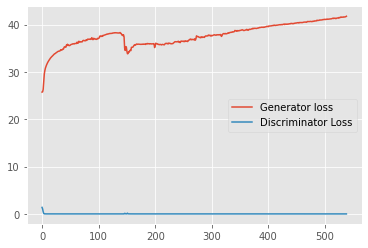

In [218]:
# plot and save the generator and discriminator loss
plt.figure()
losses_g_fixed = [i.detach() for i in losses_g]
losses_d_fixed = [i.detach() for i in losses_d]
plt.plot(losses_g_fixed, label='Generator loss')
plt.plot(losses_d_fixed, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss_can1.png')